# 1. DDoS Detection on IoT - Unique Model - L5 - 23 Features - VQ VAE

## 1.1 Imports

In [1]:
import os
os.environ['PYTHONHASHSEED'] = '0'
os.environ["CUDA_VISIBLE_DEVICES"]="-1"
os.environ["TF_CUDNN_USE_AUTOTUNE"]="0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
tf.get_logger().setLevel('WARN')
tf.random.set_seed(2023)

import numpy as np
np.random.seed(2023)

import random as rn
rn.seed(2023)

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime
import time

from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_probability as tfp

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import warnings
warnings.filterwarnings('ignore')

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')

import seaborn as sns
# sns.set(color_codes=True)

from keras.layers import Input, Dense
from keras.models import Model
from tensorflow.keras import backend as K

import json, codecs

# 2. Import Datasets and Normalize

## 2.1 Danmini Doorbell

In [2]:
# Benign traffic

dd_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_dd_benign = dd_benign.copy(deep=True)

columns = list(df_dd_benign.columns)
chosen_columns = []

for column in columns:
    if column.find('L5') != -1:             # selecionando apenas intervalo L5 (100 ms)
        chosen_columns.append(column)

df_dd_benign = pd.DataFrame(df_dd_benign, columns = chosen_columns)

# Mirai attacks
dd_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_ack = dd_mirai_ack.copy(deep=True)
df_dd_mirai_ack = pd.DataFrame(df_dd_mirai_ack, columns = chosen_columns)

dd_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_scan = dd_mirai_scan.copy(deep=True)
df_dd_mirai_scan = pd.DataFrame(df_dd_mirai_scan, columns = chosen_columns)

dd_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_syn = dd_mirai_syn.copy(deep=True)
df_dd_mirai_syn = pd.DataFrame(df_dd_mirai_syn, columns = chosen_columns)

dd_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udp = dd_mirai_udp.copy(deep=True)
df_dd_mirai_udp = pd.DataFrame(df_dd_mirai_udp, columns = chosen_columns)

dd_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_dd_mirai_udpplain = dd_mirai_udpplain.copy(deep=True)
df_dd_mirai_udpplain = pd.DataFrame(df_dd_mirai_udpplain, columns = chosen_columns)

# Bashlite attacks
dd_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_combo = dd_bashlite_combo.copy(deep=True)
df_dd_bashlite_combo = pd.DataFrame(df_dd_bashlite_combo, columns = chosen_columns)

dd_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_junk = dd_bashlite_junk.copy(deep=True)
df_dd_bashlite_junk = pd.DataFrame(df_dd_bashlite_junk, columns = chosen_columns)

dd_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_scan = dd_bashlite_scan.copy(deep=True)
df_dd_bashlite_scan = pd.DataFrame(df_dd_bashlite_scan, columns = chosen_columns)

dd_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_udp = dd_bashlite_udp.copy(deep=True)
df_dd_bashlite_udp = pd.DataFrame(df_dd_bashlite_udp, columns = chosen_columns)

dd_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Danmini_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_dd_bashlite_tcp = dd_bashlite_tcp.copy(deep=True)
df_dd_bashlite_tcp = pd.DataFrame(df_dd_bashlite_tcp, columns = chosen_columns)

In [3]:
df_dd_benign.head()

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,H_L5_weight,H_L5_mean,H_L5_variance,HH_L5_weight,HH_L5_mean,HH_L5_std,HH_L5_magnitude,...,HH_jit_L5_weight,HH_jit_L5_mean,HH_jit_L5_variance,HpHp_L5_weight,HpHp_L5_mean,HpHp_L5_std,HpHp_L5_magnitude,HpHp_L5_radius,HpHp_L5_covariance,HpHp_L5_pcc
0,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,60.000000,...,1.000000,1.505662e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0
1,1.000000,354.000000,0.000000,1.000000,354.000000,0.000005,1.000000,354.000000,0.002143,354.000000,...,1.000000,4.980575e+00,4.230000e-07,1.000000,354.000000,0.002143,354.000000,0.000005,0.0,0.0
2,1.857879,360.458980,35.789338,1.857879,360.458979,35.789342,1.857879,360.458979,5.982419,360.458979,...,1.857879,2.323596e+00,6.056226e+00,1.857879,360.458979,5.982419,360.458979,35.789342,0.0,0.0
3,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,1.000000,337.000000,0.000000,337.000000,...,1.000000,1.505662e+09,0.000000e+00,1.000000,337.000000,0.000000,337.000000,0.000000,0.0,0.0
4,1.680223,172.140917,18487.448750,1.680223,172.140917,18487.448750,1.000000,60.000000,0.000000,524.399648,...,1.000000,1.505662e+09,0.000000e+00,1.000000,60.000000,0.000000,60.000000,0.000000,0.0,0.0


In [4]:
scaler = MinMaxScaler()

df_dd_benign_norm = scaler.fit_transform(df_dd_benign)
df_dd_miraiack_norm = scaler.fit_transform(df_dd_mirai_ack)
df_dd_miraiscan_norm = scaler.fit_transform(df_dd_mirai_scan)
df_dd_miraisyn_norm = scaler.fit_transform(df_dd_mirai_syn)
df_dd_miraiudp_norm = scaler.fit_transform(df_dd_mirai_udp)
df_dd_miraiudpplain_norm = scaler.fit_transform(df_dd_mirai_udpplain)

df_dd_bashlitecombo_norm = scaler.fit_transform(df_dd_bashlite_combo)
df_dd_bashlitejunk_norm = scaler.fit_transform(df_dd_bashlite_junk)
df_dd_bashlitescan_norm = scaler.fit_transform(df_dd_bashlite_scan)
df_dd_bashliteudp_norm = scaler.fit_transform(df_dd_bashlite_udp)
df_dd_bashlitetcp_norm = scaler.fit_transform(df_dd_bashlite_tcp)

## 2.2 Ecobee Thermostat

In [5]:
# Benign traffic

et_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_et_benign = et_benign.copy(deep=True)
df_et_benign = pd.DataFrame(df_et_benign, columns = chosen_columns)

# Mirai

et_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_ack = et_mirai_ack.copy(deep=True)
df_et_mirai_ack = pd.DataFrame(df_et_mirai_ack, columns = chosen_columns)

et_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_scan = et_mirai_scan.copy(deep=True)
df_et_mirai_scan = pd.DataFrame(df_et_mirai_scan, columns = chosen_columns)

et_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_syn = et_mirai_syn.copy(deep=True)
df_et_mirai_syn = pd.DataFrame(df_et_mirai_syn, columns = chosen_columns)

et_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udp = et_mirai_udp.copy(deep=True)
df_et_mirai_udp = pd.DataFrame(df_et_mirai_udp, columns = chosen_columns)

et_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_et_mirai_udpplain = et_mirai_udpplain.copy(deep=True)
df_et_mirai_udpplain = pd.DataFrame(df_et_mirai_udpplain, columns = chosen_columns)

# Bashlite

et_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_combo = et_bashlite_combo.copy(deep=True)
df_et_bashlite_combo = pd.DataFrame(df_et_bashlite_combo, columns = chosen_columns)

et_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_junk = et_bashlite_junk.copy(deep=True)
df_et_bashlite_junk = pd.DataFrame(df_et_bashlite_junk, columns = chosen_columns)

et_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_scan = et_bashlite_scan.copy(deep=True)
df_et_bashlite_scan = pd.DataFrame(df_et_bashlite_scan, columns = chosen_columns)

et_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_udp = et_bashlite_udp.copy(deep=True)
df_et_bashlite_udp = pd.DataFrame(df_et_bashlite_udp, columns = chosen_columns)

et_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ecobee_Thermostat/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_et_bashlite_tcp = et_bashlite_tcp.copy(deep=True)
df_et_bashlite_tcp = pd.DataFrame(df_et_bashlite_tcp, columns = chosen_columns)

In [6]:
df_et_benign_norm = scaler.fit_transform(df_et_benign)

df_et_miraiack_norm = scaler.fit_transform(df_et_mirai_ack)
df_et_miraiscan_norm = scaler.fit_transform(df_et_mirai_scan)
df_et_miraisyn_norm = scaler.fit_transform(df_et_mirai_syn)
df_et_miraiudp_norm = scaler.fit_transform(df_et_mirai_udp)
df_et_miraiudpplain_norm = scaler.fit_transform(df_et_mirai_udpplain)

df_et_bashlitecombo_norm = scaler.fit_transform(df_et_bashlite_combo)
df_et_bashlitejunk_norm = scaler.fit_transform(df_et_bashlite_junk)
df_et_bashlitescan_norm = scaler.fit_transform(df_et_bashlite_scan)
df_et_bashliteudp_norm = scaler.fit_transform(df_et_bashlite_udp)
df_et_bashlitetcp_norm = scaler.fit_transform(df_et_bashlite_tcp)

## 2.3 Ennio Doorbell

In [7]:
# Benign traffic

ed_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_ed_benign = ed_benign.copy(deep=True)
df_ed_benign = pd.DataFrame(df_ed_benign, columns = chosen_columns)

# Only Bashlite

ed_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_combo = ed_bashlite_combo.copy(deep=True)
df_ed_bashlite_combo = pd.DataFrame(df_ed_bashlite_combo, columns = chosen_columns)

ed_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_junk = ed_bashlite_junk.copy(deep=True)
df_ed_bashlite_junk = pd.DataFrame(df_ed_bashlite_junk, columns = chosen_columns)

ed_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_scan = ed_bashlite_scan.copy(deep=True)
df_ed_bashlite_scan = pd.DataFrame(df_ed_bashlite_scan, columns = chosen_columns)

ed_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_udp = ed_bashlite_udp.copy(deep=True)
df_ed_bashlite_udp = pd.DataFrame(df_ed_bashlite_udp, columns = chosen_columns)

ed_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Ennio_Doorbell/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_ed_bashlite_tcp = ed_bashlite_tcp.copy(deep=True)
df_ed_bashlite_tcp = pd.DataFrame(df_ed_bashlite_tcp, columns = chosen_columns)

In [8]:
df_ed_benign_norm = scaler.fit_transform(df_ed_benign)

df_ed_bashlitecombo_norm = scaler.fit_transform(df_ed_bashlite_combo)
df_ed_bashlitejunk_norm = scaler.fit_transform(df_ed_bashlite_junk)
df_ed_bashlitescan_norm = scaler.fit_transform(df_ed_bashlite_scan)
df_ed_bashliteudp_norm = scaler.fit_transform(df_ed_bashlite_udp)
df_ed_bashlitetcp_norm = scaler.fit_transform(df_ed_bashlite_tcp)

## 2.4 Philips Baby Monitor

In [9]:
# Benign traffic

pb_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_pb_benign = pb_benign.copy(deep=True)
df_pb_benign = pd.DataFrame(df_pb_benign, columns = chosen_columns)        
        
# Mirai

pb_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_ack = pb_mirai_ack.copy(deep=True)
df_pb_mirai_ack = pd.DataFrame(df_pb_mirai_ack, columns = chosen_columns)

pb_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_scan = pb_mirai_scan.copy(deep=True)
df_pb_mirai_scan = pd.DataFrame(df_pb_mirai_scan, columns = chosen_columns)

pb_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_syn = pb_mirai_syn.copy(deep=True)
df_pb_mirai_syn = pd.DataFrame(df_pb_mirai_syn, columns = chosen_columns)

pb_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udp = pb_mirai_udp.copy(deep=True)
df_pb_mirai_udp = pd.DataFrame(df_pb_mirai_udp, columns = chosen_columns)

pb_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_pb_mirai_udpplain = pb_mirai_udpplain.copy(deep=True)
df_pb_mirai_udpplain = pd.DataFrame(df_pb_mirai_udpplain, columns = chosen_columns)

# Bashlite

pb_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_combo = pb_bashlite_combo.copy(deep=True)
df_pb_bashlite_combo = pd.DataFrame(df_pb_bashlite_combo, columns = chosen_columns)

pb_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_junk = pb_bashlite_junk.copy(deep=True)
df_pb_bashlite_junk = pd.DataFrame(df_pb_bashlite_junk, columns = chosen_columns)

pb_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_scan = pb_bashlite_scan.copy(deep=True)
df_pb_bashlite_scan = pd.DataFrame(df_pb_bashlite_scan, columns = chosen_columns)

pb_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_udp = pb_bashlite_udp.copy(deep=True)
df_pb_bashlite_udp = pd.DataFrame(df_pb_bashlite_udp, columns = chosen_columns)

pb_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Philips_B120N10_Baby_Monitor/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_pb_bashlite_tcp = pb_bashlite_tcp.copy(deep=True)
df_pb_bashlite_tcp = pd.DataFrame(df_pb_bashlite_tcp, columns = chosen_columns)

In [10]:
df_pb_benign_norm = scaler.fit_transform(df_pb_benign)

df_pb_miraiack_norm = scaler.fit_transform(df_pb_mirai_ack)
df_pb_miraiscan_norm = scaler.fit_transform(df_pb_mirai_scan)
df_pb_miraisyn_norm = scaler.fit_transform(df_pb_mirai_syn)
df_pb_miraiudp_norm = scaler.fit_transform(df_pb_mirai_udp)
df_pb_miraiudpplain_norm = scaler.fit_transform(df_pb_mirai_udpplain)

df_pb_bashlitecombo_norm = scaler.fit_transform(df_pb_bashlite_combo)
df_pb_bashlitejunk_norm = scaler.fit_transform(df_pb_bashlite_junk)
df_pb_bashlitescan_norm = scaler.fit_transform(df_pb_bashlite_scan)
df_pb_bashliteudp_norm = scaler.fit_transform(df_pb_bashlite_udp)
df_pb_bashlitetcp_norm = scaler.fit_transform(df_pb_bashlite_tcp)

## 2.5 Security Camera

In [11]:
# Benign traffic

p7_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p7_benign = p7_benign.copy(deep=True)
df_p7_benign = pd.DataFrame(df_p7_benign, columns = chosen_columns)    

# Mirai

p7_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_ack = p7_mirai_ack.copy(deep=True)
df_p7_mirai_ack = pd.DataFrame(df_p7_mirai_ack, columns = chosen_columns)  

p7_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_scan = p7_mirai_scan.copy(deep=True)
df_p7_mirai_scan = pd.DataFrame(df_p7_mirai_scan, columns = chosen_columns)

p7_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_syn = p7_mirai_syn.copy(deep=True)
df_p7_mirai_syn = pd.DataFrame(df_p7_mirai_syn, columns = chosen_columns)

p7_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udp = p7_mirai_udp.copy(deep=True)
df_p7_mirai_udp = pd.DataFrame(df_p7_mirai_udp, columns = chosen_columns)

p7_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p7_mirai_udpplain = p7_mirai_udpplain.copy(deep=True)
df_p7_mirai_udpplain = pd.DataFrame(df_p7_mirai_udpplain, columns = chosen_columns)

# Bashlite

p7_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_combo = p7_bashlite_combo.copy(deep=True)
df_p7_bashlite_combo = pd.DataFrame(df_p7_bashlite_combo, columns = chosen_columns)

p7_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_junk = p7_bashlite_junk.copy(deep=True)
df_p7_bashlite_junk = pd.DataFrame(df_p7_bashlite_junk, columns = chosen_columns)

p7_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_scan = p7_bashlite_scan.copy(deep=True)
df_p7_bashlite_scan = pd.DataFrame(df_p7_bashlite_scan, columns = chosen_columns)

p7_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_udp = p7_bashlite_udp.copy(deep=True)
df_p7_bashlite_udp = pd.DataFrame(df_p7_bashlite_udp, columns = chosen_columns)

p7_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_737E_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p7_bashlite_tcp = p7_bashlite_tcp.copy(deep=True)
df_p7_bashlite_tcp = pd.DataFrame(df_p7_bashlite_tcp, columns = chosen_columns)

In [12]:
df_p7_benign_norm = scaler.fit_transform(df_p7_benign)

df_p7_miraiack_norm = scaler.fit_transform(df_p7_mirai_ack)
df_p7_miraiscan_norm = scaler.fit_transform(df_p7_mirai_scan)
df_p7_miraisyn_norm = scaler.fit_transform(df_p7_mirai_syn)
df_p7_miraiudp_norm = scaler.fit_transform(df_p7_mirai_udp)
df_p7_miraiudpplain_norm = scaler.fit_transform(df_p7_mirai_udpplain)

df_p7_bashlitecombo_norm = scaler.fit_transform(df_p7_bashlite_combo)
df_p7_bashlitejunk_norm = scaler.fit_transform(df_p7_bashlite_junk)
df_p7_bashlitescan_norm = scaler.fit_transform(df_p7_bashlite_scan)
df_p7_bashliteudp_norm = scaler.fit_transform(df_p7_bashlite_udp)
df_p7_bashlitetcp_norm = scaler.fit_transform(df_p7_bashlite_tcp)

## 2.6 Security Camera

In [13]:
# Benign traffic

p8_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_p8_benign = p8_benign.copy(deep=True)
df_p8_benign = pd.DataFrame(df_p8_benign, columns = chosen_columns)  

# Mirai

p8_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_ack = p8_mirai_ack.copy(deep=True)
df_p8_mirai_ack = pd.DataFrame(df_p8_mirai_ack, columns = chosen_columns) 

p8_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_scan = p8_mirai_scan.copy(deep=True)
df_p8_mirai_scan = pd.DataFrame(df_p8_mirai_scan, columns = chosen_columns) 

p8_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_syn = p8_mirai_syn.copy(deep=True)
df_p8_mirai_syn = pd.DataFrame(df_p8_mirai_syn, columns = chosen_columns) 

p8_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udp = p8_mirai_udp.copy(deep=True)
df_p8_mirai_udp = pd.DataFrame(df_p8_mirai_udp, columns = chosen_columns) 

p8_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_p8_mirai_udpplain = p8_mirai_udpplain.copy(deep=True)
df_p8_mirai_udpplain = pd.DataFrame(df_p8_mirai_udpplain, columns = chosen_columns) 

# Bashlite

p8_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_combo = p8_bashlite_combo.copy(deep=True)
df_p8_bashlite_combo = pd.DataFrame(df_p8_bashlite_combo, columns = chosen_columns) 

p8_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_junk = p8_bashlite_junk.copy(deep=True)
df_p8_bashlite_junk = pd.DataFrame(df_p8_bashlite_junk, columns = chosen_columns)

p8_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_scan = p8_bashlite_scan.copy(deep=True)
df_p8_bashlite_scan = pd.DataFrame(df_p8_bashlite_scan, columns = chosen_columns)

p8_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_udp = p8_bashlite_udp.copy(deep=True)
df_p8_bashlite_udp = pd.DataFrame(df_p8_bashlite_udp, columns = chosen_columns)

p8_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Provision_PT_838_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_p8_bashlite_tcp = p8_bashlite_tcp.copy(deep=True)
df_p8_bashlite_tcp = pd.DataFrame(df_p8_bashlite_tcp, columns = chosen_columns)

In [14]:
df_p8_benign_norm = scaler.fit_transform(df_p8_benign)

df_p8_miraiack_norm = scaler.fit_transform(df_p8_mirai_ack)
df_p8_miraiscan_norm = scaler.fit_transform(df_p8_mirai_scan)
df_p8_miraisyn_norm = scaler.fit_transform(df_p8_mirai_syn)
df_p8_miraiudp_norm = scaler.fit_transform(df_p8_mirai_udp)
df_p8_miraiudpplain_norm = scaler.fit_transform(df_p8_mirai_udpplain)

df_p8_bashlitecombo_norm = scaler.fit_transform(df_p8_bashlite_combo)
df_p8_bashlitejunk_norm = scaler.fit_transform(df_p8_bashlite_junk)
df_p8_bashlitescan_norm = scaler.fit_transform(df_p8_bashlite_scan)
df_p8_bashliteudp_norm = scaler.fit_transform(df_p8_bashlite_udp)
df_p8_bashlitetcp_norm = scaler.fit_transform(df_p8_bashlite_tcp)

## 2.7 Security Camera

In [15]:
# Benign traffic

s2_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s2_benign = s2_benign.copy(deep=True)
df_s2_benign = pd.DataFrame(df_s2_benign, columns = chosen_columns)  

# Mirai

s2_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_ack = s2_mirai_ack.copy(deep=True)
df_s2_mirai_ack = pd.DataFrame(df_s2_mirai_ack, columns = chosen_columns)

s2_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_scan = s2_mirai_scan.copy(deep=True)
df_s2_mirai_scan = pd.DataFrame(df_s2_mirai_scan, columns = chosen_columns)

s2_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_syn = s2_mirai_syn.copy(deep=True)
df_s2_mirai_syn = pd.DataFrame(df_s2_mirai_syn, columns = chosen_columns)

s2_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udp = s2_mirai_udp.copy(deep=True)
df_s2_mirai_udp = pd.DataFrame(df_s2_mirai_udp, columns = chosen_columns)

s2_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s2_mirai_udpplain = s2_mirai_udpplain.copy(deep=True)
df_s2_mirai_udpplain = pd.DataFrame(df_s2_mirai_udpplain, columns = chosen_columns)

# Bashlite

s2_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_combo = s2_bashlite_combo.copy(deep=True)
df_s2_bashlite_combo = pd.DataFrame(df_s2_bashlite_combo, columns = chosen_columns)

s2_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_junk = s2_bashlite_junk.copy(deep=True)
df_s2_bashlite_junk = pd.DataFrame(df_s2_bashlite_junk, columns = chosen_columns)

s2_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_scan = s2_bashlite_scan.copy(deep=True)
df_s2_bashlite_scan = pd.DataFrame(df_s2_bashlite_scan, columns = chosen_columns)

s2_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_udp = s2_bashlite_udp.copy(deep=True)
df_s2_bashlite_udp = pd.DataFrame(df_s2_bashlite_udp, columns = chosen_columns)

s2_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1002_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s2_bashlite_tcp = s2_bashlite_tcp.copy(deep=True)
df_s2_bashlite_tcp = pd.DataFrame(df_s2_bashlite_tcp, columns = chosen_columns)

In [16]:
df_s2_benign_norm = scaler.fit_transform(df_s2_benign)

df_s2_miraiack_norm = scaler.fit_transform(df_s2_mirai_ack)
df_s2_miraiscan_norm = scaler.fit_transform(df_s2_mirai_scan)
df_s2_miraisyn_norm = scaler.fit_transform(df_s2_mirai_syn)
df_s2_miraiudp_norm = scaler.fit_transform(df_s2_mirai_udp)
df_s2_miraiudpplain_norm = scaler.fit_transform(df_s2_mirai_udpplain)

df_s2_bashlitecombo_norm = scaler.fit_transform(df_s2_bashlite_combo)
df_s2_bashlitejunk_norm = scaler.fit_transform(df_s2_bashlite_junk)
df_s2_bashlitescan_norm = scaler.fit_transform(df_s2_bashlite_scan)
df_s2_bashliteudp_norm = scaler.fit_transform(df_s2_bashlite_udp)
df_s2_bashlitetcp_norm = scaler.fit_transform(df_s2_bashlite_tcp)

## 2.8 Security Camera

In [17]:
# Benign traffic

s3_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_s3_benign = s3_benign.copy(deep=True)
df_s3_benign = pd.DataFrame(df_s3_benign, columns = chosen_columns)

# Mirai

s3_mirai_ack = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/ack.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_ack = s3_mirai_ack.copy(deep=True)
df_s3_mirai_ack = pd.DataFrame(df_s3_mirai_ack, columns = chosen_columns)

s3_mirai_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_scan = s3_mirai_scan.copy(deep=True)
df_s3_mirai_scan = pd.DataFrame(df_s3_mirai_scan, columns = chosen_columns)

s3_mirai_syn = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/syn.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_syn = s3_mirai_syn.copy(deep=True)
df_s3_mirai_syn = pd.DataFrame(df_s3_mirai_syn, columns = chosen_columns)

s3_mirai_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udp = s3_mirai_udp.copy(deep=True)
df_s3_mirai_udp = pd.DataFrame(df_s3_mirai_udp, columns = chosen_columns)

s3_mirai_udpplain = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/mirai_attacks/udpplain.csv', encoding = "utf-8", sep = ',' ) 
df_s3_mirai_udpplain = s3_mirai_udpplain.copy(deep=True)
df_s3_mirai_udpplain = pd.DataFrame(df_s3_mirai_udpplain, columns = chosen_columns)

# Bashlite

s3_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_combo = s3_bashlite_combo.copy(deep=True)
df_s3_bashlite_combo = pd.DataFrame(df_s3_bashlite_combo, columns = chosen_columns)

s3_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_junk = s3_bashlite_junk.copy(deep=True)
df_s3_bashlite_junk = pd.DataFrame(df_s3_bashlite_junk, columns = chosen_columns)

s3_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_scan = s3_bashlite_scan.copy(deep=True)
df_s3_bashlite_scan = pd.DataFrame(df_s3_bashlite_scan, columns = chosen_columns)

s3_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_udp = s3_bashlite_udp.copy(deep=True)
df_s3_bashlite_udp = pd.DataFrame(df_s3_bashlite_udp, columns = chosen_columns)

s3_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/SimpleHome_XCS7_1003_WHT_Security_Camera/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_s3_bashlite_tcp = s3_bashlite_tcp.copy(deep=True)
df_s3_bashlite_tcp = pd.DataFrame(df_s3_bashlite_tcp, columns = chosen_columns)

In [18]:
df_s3_benign_norm = scaler.fit_transform(df_s3_benign)

df_s3_miraiack_norm = scaler.fit_transform(df_s3_mirai_ack)
df_s3_miraiscan_norm = scaler.fit_transform(df_s3_mirai_scan)
df_s3_miraisyn_norm = scaler.fit_transform(df_s3_mirai_syn)
df_s3_miraiudp_norm = scaler.fit_transform(df_s3_mirai_udp)
df_s3_miraiudpplain_norm = scaler.fit_transform(df_s3_mirai_udpplain)

df_s3_bashlitecombo_norm = scaler.fit_transform(df_s3_bashlite_combo)
df_s3_bashlitejunk_norm = scaler.fit_transform(df_s3_bashlite_junk)
df_s3_bashlitescan_norm = scaler.fit_transform(df_s3_bashlite_scan)
df_s3_bashliteudp_norm = scaler.fit_transform(df_s3_bashlite_udp)
df_s3_bashlitetcp_norm = scaler.fit_transform(df_s3_bashlite_tcp)

## 2.9 Samsung Webcam

In [19]:
# Benign traffic

sw_benign = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/benign_traffic.csv', encoding = "utf-8", sep = ',' ) 
df_sw_benign = sw_benign.copy(deep=True)
df_sw_benign = pd.DataFrame(df_sw_benign, columns = chosen_columns)

# Bashlite Only

sw_bashlite_combo = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/combo.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_combo = sw_bashlite_combo.copy(deep=True)
df_sw_bashlite_combo = pd.DataFrame(df_sw_bashlite_combo, columns = chosen_columns)

sw_bashlite_junk = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/junk.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_junk = sw_bashlite_junk.copy(deep=True)
df_sw_bashlite_junk = pd.DataFrame(df_sw_bashlite_junk, columns = chosen_columns)

sw_bashlite_scan = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/scan.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_scan = sw_bashlite_scan.copy(deep=True)
df_sw_bashlite_scan = pd.DataFrame(df_sw_bashlite_scan, columns = chosen_columns)

sw_bashlite_udp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/udp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_udp = sw_bashlite_udp.copy(deep=True)
df_sw_bashlite_udp = pd.DataFrame(df_sw_bashlite_udp, columns = chosen_columns)

sw_bashlite_tcp = pd.read_csv('/mnt/extra/2023-1_10Periodo/Poc_II/nbaiot/Samsung_SNH_1011_N_Webcam/gafgyt_attacks/tcp.csv', encoding = "utf-8", sep = ',' ) 
df_sw_bashlite_tcp = sw_bashlite_tcp.copy(deep=True)
df_sw_bashlite_tcp = pd.DataFrame(df_sw_bashlite_tcp, columns = chosen_columns)

In [20]:
df_sw_benign_norm = scaler.fit_transform(df_sw_benign)

df_sw_bashlitecombo_norm = scaler.fit_transform(df_sw_bashlite_combo)
df_sw_bashlitejunk_norm = scaler.fit_transform(df_sw_bashlite_junk)
df_sw_bashlitescan_norm = scaler.fit_transform(df_sw_bashlite_scan)
df_sw_bashliteudp_norm = scaler.fit_transform(df_sw_bashlite_udp)
df_sw_bashlitetcp_norm = scaler.fit_transform(df_sw_bashlite_tcp)

# 3. VQ VAE - Attack Detection

## 3.1 Model

In [21]:
# Train set
len_dd_benign_train = int(0.7 * len(df_dd_benign_norm))
X_train_dd_benign = df_dd_benign_norm[:len_dd_benign_train]

len_et_benign_train = int(0.7 * len(df_et_benign_norm))
X_train_et_benign = df_et_benign_norm[:len_et_benign_train]

len_ed_benign_train = int(0.7 * len(df_ed_benign_norm))
X_train_ed_benign = df_ed_benign_norm[:len_ed_benign_train]

len_pb_benign_train = int(0.7 * len(df_pb_benign_norm))
X_train_pb_benign = df_pb_benign_norm[:len_pb_benign_train]

len_p7_benign_train = int(0.7 * len(df_p7_benign_norm))
X_train_p7_benign = df_p7_benign_norm[:len_p7_benign_train]

len_p8_benign_train = int(0.7 * len(df_p8_benign_norm))
X_train_p8_benign = df_p8_benign_norm[:len_p8_benign_train]

len_s2_benign_train = int(0.7 * len(df_s2_benign_norm))
X_train_s2_benign = df_s2_benign_norm[:len_s2_benign_train]

len_s3_benign_train = int(0.7 * len(df_s3_benign_norm))
X_train_s3_benign = df_s3_benign_norm[:len_s3_benign_train]

len_sw_benign_train = int(0.7 * len(df_sw_benign_norm))
X_train_sw_benign = df_sw_benign_norm[:len_sw_benign_train]

X_train_AE = np.concatenate([X_train_dd_benign, X_train_et_benign, X_train_ed_benign, X_train_pb_benign, X_train_p7_benign, 
                              X_train_p8_benign, X_train_s2_benign, X_train_s3_benign])

# Test set - 30% benign and the rest is attack
X_test_dd_benign = df_dd_benign_norm[len_dd_benign_train:]
X_test_et_benign = df_et_benign_norm[len_et_benign_train:]
X_test_ed_benign = df_ed_benign_norm[len_ed_benign_train:]
X_test_pb_benign = df_pb_benign_norm[len_pb_benign_train:]
X_test_p7_benign = df_p7_benign_norm[len_p7_benign_train:]
X_test_p8_benign = df_p8_benign_norm[len_p8_benign_train:]
X_test_s2_benign = df_s2_benign_norm[len_s2_benign_train:]
X_test_s3_benign = df_s3_benign_norm[len_s3_benign_train:]
X_test_sw_benign = df_sw_benign_norm[len_sw_benign_train:]

X_test_benign = np.concatenate([X_test_dd_benign, X_test_et_benign, X_test_ed_benign, X_test_pb_benign, X_test_p7_benign, 
                                X_test_p8_benign, X_test_s2_benign, X_test_s3_benign, X_test_sw_benign])

# 30% benign + attacks
X_test_AE = np.concatenate([X_test_benign,
                             df_dd_miraiack_norm, df_dd_miraiscan_norm, df_dd_miraisyn_norm, df_dd_miraiudp_norm, df_dd_miraiudpplain_norm,
                             df_dd_bashlitecombo_norm, df_dd_bashlitejunk_norm, df_dd_bashlitescan_norm, df_dd_bashliteudp_norm, df_dd_bashlitetcp_norm,
                             df_et_miraiack_norm, df_et_miraiscan_norm, df_et_miraisyn_norm, df_et_miraiudp_norm, df_et_miraiudpplain_norm,
                             df_et_bashlitecombo_norm, df_et_bashlitejunk_norm, df_et_bashlitescan_norm, df_et_bashliteudp_norm, df_et_bashlitetcp_norm,
                             df_ed_bashlitecombo_norm, df_ed_bashlitejunk_norm, df_ed_bashlitescan_norm, df_ed_bashliteudp_norm, df_ed_bashlitetcp_norm,
                             df_pb_miraiack_norm, df_pb_miraiscan_norm, df_pb_miraisyn_norm, df_pb_miraiudp_norm, df_pb_miraiudpplain_norm,
                             df_pb_bashlitecombo_norm, df_pb_bashlitejunk_norm, df_pb_bashlitescan_norm, df_pb_bashliteudp_norm, df_pb_bashlitetcp_norm,
                             df_p7_miraiack_norm, df_p7_miraiscan_norm, df_p7_miraisyn_norm, df_p7_miraiudp_norm, df_p7_miraiudpplain_norm,
                             df_p7_bashlitecombo_norm, df_p7_bashlitejunk_norm, df_p7_bashlitescan_norm, df_p7_bashliteudp_norm, df_p7_bashlitetcp_norm,
                             df_p8_miraiack_norm, df_p8_miraiscan_norm, df_p8_miraisyn_norm, df_p8_miraiudp_norm, df_p8_miraiudpplain_norm,
                             df_p8_bashlitecombo_norm, df_p8_bashlitejunk_norm, df_p8_bashlitescan_norm, df_p8_bashliteudp_norm, df_p8_bashlitetcp_norm,
                             df_s2_miraiack_norm, df_s2_miraiscan_norm, df_s2_miraisyn_norm, df_s2_miraiudp_norm, df_s2_miraiudpplain_norm,
                             df_s2_bashlitecombo_norm, df_s2_bashlitejunk_norm, df_s2_bashlitescan_norm, df_s2_bashliteudp_norm, df_s2_bashlitetcp_norm,
                             df_s3_miraiack_norm, df_s3_miraiscan_norm, df_s3_miraisyn_norm, df_s3_miraiudp_norm, df_s3_miraiudpplain_norm,
                             df_s3_bashlitecombo_norm, df_s3_bashlitejunk_norm, df_s3_bashlitescan_norm, df_s3_bashliteudp_norm, df_s3_bashlitetcp_norm,
                             df_sw_bashlitecombo_norm, df_sw_bashlitejunk_norm, df_sw_bashlitescan_norm, df_sw_bashliteudp_norm, df_sw_bashlitetcp_norm])

X_train_label = np.zeros(len(X_train_AE))

Y_test_AE = np.ones(len(X_test_AE))
Y_test_AE[:len(X_test_benign)] = 0

In [22]:
X_train_AE.shape, X_test_AE.shape, Y_test_AE.shape

((352643, 23), (6673458, 23), (6673458,))

In [23]:
def saveHist(path, history):
    with codecs.open(path, 'w', encoding='utf-8') as f:
        json.dump(history, f, separators=(',', ':'), sort_keys=True, indent=4) 

def loadHist(path):
    n = {} # set history to empty
    if os.path.exists(path): # reload history if it exists
        with codecs.open(path, 'r', encoding='utf-8') as f:
            n = json.loads(f.read())
    return n

def appendHist(h1, h2):
    if h1 == {}:
        return h2
    else:
        dest = {}
        for key, value in h1.items():
            dest[key] = value + h2[key]
        return dest

In [24]:
# Parameters
original_dim = X_train_AE.shape[1]
input_shape = (original_dim,)
intermediate_dim = int(original_dim / 2)
latent_dim = int(original_dim / 3)

In [25]:
class VectorQuantizer(layers.Layer):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25, **kwargs):
        super().__init__(**kwargs)
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings

        # The `beta` parameter is best kept between [0.25, 2] as per the paper.
        self.beta = beta

        # Initialize the embeddings which we will quantize.
        w_init = tf.random_uniform_initializer()
        self.embeddings = tf.Variable(
            initial_value=w_init(
                shape=(self.embedding_dim, self.num_embeddings), dtype="float32"
            ),
            trainable=True,
            name="embeddings_vqvae",
        )

    def call(self, x):
        # Calculate the input shape of the inputs and
        # then flatten the inputs keeping `embedding_dim` intact.
        input_shape = tf.shape(x)
        flattened = tf.reshape(x, [-1, self.embedding_dim])

        # Quantization.
        encoding_indices = self.get_code_indices(flattened)
        encodings = tf.one_hot(encoding_indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)

        # Reshape the quantized values back to the original input shape
        quantized = tf.reshape(quantized, input_shape)

        # Calculate vector quantization loss and add that to the layer. You can learn more
        # about adding losses to different layers here:
        # https://keras.io/guides/making_new_layers_and_models_via_subclassing/. Check
        # the original paper to get a handle on the formulation of the loss function.
        commitment_loss = tf.reduce_mean((tf.stop_gradient(quantized) - x) ** 2)
        codebook_loss = tf.reduce_mean((quantized - tf.stop_gradient(x)) ** 2)
        self.add_loss(self.beta * commitment_loss + codebook_loss)

        # Straight-through estimator.
        quantized = x + tf.stop_gradient(quantized - x)
        return quantized

    def get_code_indices(self, flattened_inputs):
        # Calculate L2-normalized distance between the inputs and the codes.
        similarity = tf.matmul(flattened_inputs, self.embeddings)
        distances = (
            tf.reduce_sum(flattened_inputs ** 2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings ** 2, axis=0)
            - 2 * similarity
        )

        # Derive the indices for minimum distances.
        encoding_indices = tf.argmin(distances, axis=1)
        return encoding_indices

In [26]:
# Reparameterization trick
def sample(args):
    z_mean, z_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape = (batch, dim))
    
    return z_mean + K.exp(0.5 * z_var) * epsilon

In [27]:
def get_encoder(input_shape, latent_dim=latent_dim):
    encoder_inputs = Input(shape = input_shape, name = 'encoder_input')
    x = Dense(intermediate_dim, activation = 'relu')(encoder_inputs)

    z_mean = Dense(latent_dim, name = 'z_mean')(x)
    z_var = Dense(latent_dim, name = 'z_var')(x)
    z = layers.Lambda(sample, output_shape = (latent_dim,), name = 'z')([z_mean, z_var])
    
    return keras.Model(encoder_inputs, z, name="encoder")

def get_decoder(latent_dim=latent_dim):
    latent_inputs = Input(shape = (latent_dim,), name = 'z_sampling')
    x = Dense(intermediate_dim, activation = 'relu')(latent_inputs)
    decoder_outputs = Dense(original_dim, activation = 'sigmoid')(x)
    
    return keras.Model(latent_inputs, decoder_outputs, name="decoder")


In [28]:
def get_vqvae(latent_dim=latent_dim, num_embeddings=64):
    vq_layer = VectorQuantizer(num_embeddings, latent_dim, name="vector_quantizer")
    
    encoder = get_encoder(input_shape, latent_dim)
    decoder = get_decoder(latent_dim)
    
    inputs = keras.Input(shape = input_shape)
    encoder_outputs = encoder(inputs)
    quantized_latents = vq_layer(encoder_outputs)
    reconstructions = decoder(quantized_latents)
    
    return keras.Model(inputs, reconstructions, name="vq_vae")

get_vqvae().summary()

2023-06-04 20:53:06.192754: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "vq_vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 23)]              0         
                                                                 
 encoder (Functional)        (None, 7)                 432       
                                                                 
 vector_quantizer (VectorQua  (None, 7)                448       
 ntizer)                                                         
                                                                 
 decoder (Functional)        (None, 23)                364       
                                                                 
Total params: 1,244
Trainable params: 1,244
Non-trainable params: 0
_________________________________________________________________


In [29]:
class VQVAETrainer(keras.models.Model):
    def __init__(self, train_variance, latent_dim=32, num_embeddings=128, **kwargs):
        super().__init__(**kwargs)
        self.train_variance = train_variance
        self.latent_dim = latent_dim
        self.num_embeddings = num_embeddings

        self.vqvae = get_vqvae(self.latent_dim, self.num_embeddings)

        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.vq_loss_tracker = keras.metrics.Mean(name="vq_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.vq_loss_tracker,
        ]

    def train_step(self, x):
        with tf.GradientTape() as tape:
            # Outputs from the VQ-VAE.
            reconstructions = self.vqvae(x)

            # Calculate the losses.
            reconstruction_loss = (
                tf.reduce_mean((x - reconstructions) ** 2) / self.train_variance
            )
            total_loss = reconstruction_loss + sum(self.vqvae.losses)

        # Backpropagation.
        grads = tape.gradient(total_loss, self.vqvae.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.vqvae.trainable_variables))

        # Loss tracking.
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.vq_loss_tracker.update_state(sum(self.vqvae.losses))

        # Log results.
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "vqvae_loss": self.vq_loss_tracker.result(),
        }

## Train

In [30]:
epochs = 100
learning_rate = 0.001          # learning rate
batch_size = 32
history_filename = 'history.json'

data_variance = np.var(X_train_AE)

In [31]:
vqvae_trainer = VQVAETrainer(data_variance, latent_dim=latent_dim, num_embeddings=128)

vqvae_trainer.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate))

train_start = time.time()
history = vqvae_trainer.fit(X_train_AE, 
                            epochs=epochs, 
                            batch_size=batch_size,
                            shuffle=False).history
#                           validation_split = 0.10,
train_end = time.time()
train_time = train_end - train_start

print(f"Fit time: {train_time:.2f}s")

Epoch 1/100
11021/11021 [==============================] - 17s 1ms/step - loss: 1.1133 - reconstruction_loss: 0.1278 - vqvae_loss: 0.7852
Epoch 2/100
11021/11021 [==============================] - 17s 2ms/step - loss: 0.1269 - reconstruction_loss: 0.0509 - vqvae_loss: 0.0673
Epoch 3/100
11021/11021 [==============================] - 15s 1ms/step - loss: 0.1207 - reconstruction_loss: 0.0442 - vqvae_loss: 0.0706
Epoch 4/100
11021/11021 [==============================] - 16s 1ms/step - loss: 0.1234 - reconstruction_loss: 0.0420 - vqvae_loss: 0.0743
Epoch 5/100
11021/11021 [==============================] - 16s 1ms/step - loss: 0.1255 - reconstruction_loss: 0.0373 - vqvae_loss: 0.0813
Epoch 6/100
11021/11021 [==============================] - 15s 1ms/step - loss: 0.0934 - reconstruction_loss: 0.0346 - vqvae_loss: 0.0520
Epoch 7/100
11021/11021 [==============================] - 15s 1ms/step - loss: 0.0905 - reconstruction_loss: 0.0347 - vqvae_loss: 0.0497
Epoch 8/100
11021/11021 [=========

### Save and Restore the Model

In [33]:
# history_filename = 'history_26-05.json'

vqvae_trainer.save("vq_model_26-05")
saveHist(history_filename, history)

ValueError: Model <__main__.VQVAETrainer object at 0x7ffb4b017a30> cannot be saved either because the input shape is not available or because the forward pass of the model is not defined.To define a forward pass, please override `Model.call()`. To specify an input shape, either call `build(input_shape)` directly, or call the model on actual data using `Model()`, `Model.fit()`, or `Model.predict()`. If you have a custom training step, please make sure to invoke the forward pass in train step through `Model.__call__`, i.e. `model(inputs)`, as opposed to `model.call()`.

In [ ]:
# It can be used to reconstruct the model identically.
# vq_model = keras.models.load_model("vq_model_04-05")
# history = loadHist('history_04-05.json')

# model_loaded = True

# vq_model.summary()

# result = lstm_model.score(X_test, Y_test)
# print(result)

### Plot Metrics of Train

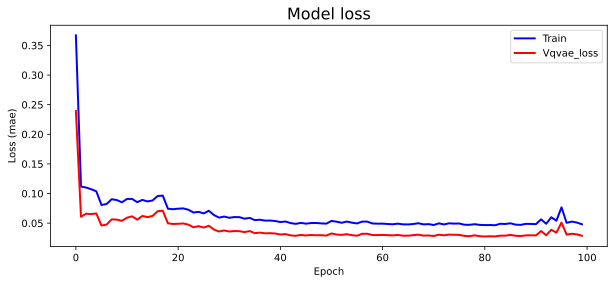

In [34]:
# plot the training losses
fig, ax = plt.subplots(figsize=(10, 4), dpi=80)

ax.plot(history['loss'], 'b', label='Train', linewidth=2)
ax.plot(history['vqvae_loss'], 'r', label='Vqvae_loss', linewidth=2)
ax.set_title('Model loss', fontsize=16)
# ax.set_ylim([0, 0.04])
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')

plt.show()

In [37]:
# plot the training accuracys
# fig, ax = plt.subplots(figsize=(10, 4), dpi=80)
# ax.plot(history['accuracy'], label='Train')
# ax.plot(history['val_accuracy'], label='Validation')
# ax.set_title('Model Accuracy', fontsize=16)
# ax.set_ylabel('Accuracy')
# # ax.set_ylim([0.45, 1.05])
# ax.set_xlabel('Epoch')
# ax.legend(loc='upper right')

# plt.show()

### Train Scenario - Only Benign

In [38]:
trained_vqvae_model = vqvae_trainer.vqvae

benign_test_start = time.time()
reconstructions_train = trained_vqvae_model.predict(X_train_AE)
benign_test_end = time.time()
benign_test_time = benign_test_end - benign_test_start

print(f"Predict time: {benign_test_time:.2f}s")

11021/11021 [==============================] - 12s 1ms/step
Predict time: 16.62s


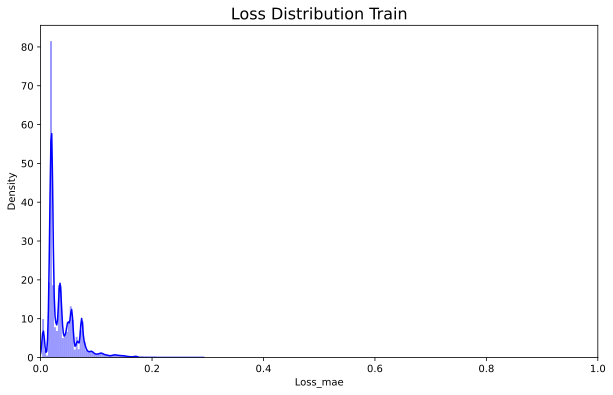

In [39]:
scored_train = pd.DataFrame(index=pd.RangeIndex.from_range(range(0, len(X_train_AE))))

scored_train['Loss_mae'] = np.mean(np.abs(reconstructions_train - X_train_AE), axis = 1)    # error vector in training data
plt.figure(figsize=(10, 6), dpi=80)
plt.title("Loss Distribution Train", fontsize=16)

sns.distplot(scored_train['Loss_mae'], bins = 80, kde=True, color='blue');

plt.xlim([0.0, 1]);

In [40]:
threshold = np.quantile(scored_train['Loss_mae'], 0.9)

scored_train['Threshold'] = threshold 
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold'] # if > then == attack

scored_train.head(10)

,Loss_mae,Threshold,Anomaly
0,0.068473,0.073675,False
1,0.070621,0.073675,False
2,0.139363,0.073675,True
3,0.103112,0.073675,True
4,0.169665,0.073675,True
5,0.254361,0.073675,True
6,0.138738,0.073675,True
7,0.095282,0.073675,True
8,0.032364,0.073675,False
9,0.080185,0.073675,True


In [41]:
print(classification_report(X_train_label, scored_train['Anomaly'], target_names=['Benign', 'Anomaly'], digits = 5))

              precision    recall  f1-score   support

      Benign    1.00000   0.90000   0.94737    352643
     Anomaly    0.00000   0.00000   0.00000         0

    accuracy                        0.90000    352643
   macro avg    0.50000   0.45000   0.47368    352643
weighted avg    1.00000   0.90000   0.94737    352643



[[317378  35265]
 [     0      0]]


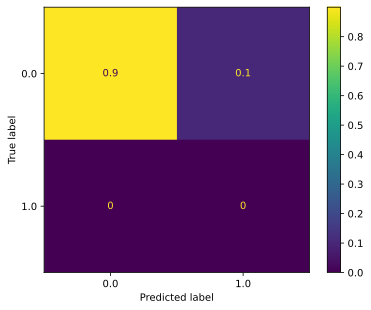

In [42]:
print(confusion_matrix(X_train_label, scored_train['Anomaly']))
ConfusionMatrixDisplay.from_predictions(X_train_label, scored_train['Anomaly'], normalize='all')

plt.show()

### Test Scenario - 100% Benign

### Test Scenario - 30% Benign + 70% Attack

In [43]:
trained_vqvae_model = vqvae_trainer.vqvae

test_start = time.time()
reconstructions_test = trained_vqvae_model.predict(X_test_AE)
test_end = time.time()
test_time = test_end - test_start

print(f"Predict time: {test_time:.2f}s")

208546/208546 [==============================] - 218s 1ms/step
Predict time: 317.49s


In [64]:
threshold = np.quantile(scored_train['Loss_mae'], 0.9)
threshold

0.07367453338605799

In [65]:
scored_test = pd.DataFrame(index=pd.RangeIndex.from_range(range(0, len(X_test_AE))))
scored_test['Loss_mae'] = np.mean(np.abs(reconstructions_test - X_test_AE), axis = 1)    # error vector in testing data

scored_test['Threshold'] = threshold 
scored_test['Anomaly'] = scored_test['Loss_mae'] > scored_test['Threshold'] # if > then == attack

scored_test.head(10)

,Loss_mae,Threshold,Anomaly
0,0.027352,0.073675,False
1,0.054756,0.073675,False
2,0.127519,0.073675,True
3,0.034172,0.073675,False
4,0.039586,0.073675,False
5,0.054946,0.073675,False
6,0.065965,0.073675,False
7,0.073854,0.073675,True
8,0.078660,0.073675,True
9,0.035725,0.073675,False


In [66]:
scored_test['Anomaly'].value_counts()

Anomaly
True     6138858
False     534600
Name: count, dtype: int64

In [67]:
# Quantidade real de dados benignos e de ataque no teste
np.unique(Y_test_AE, return_counts=True)

(array([0., 1.]), array([ 166784, 6506674]))

In [68]:
print(classification_report(Y_test_AE, scored_test['Anomaly'], target_names=['Benign', 'Anomaly'], digits = 5))

              precision    recall  f1-score   support

      Benign    0.28029   0.89842   0.42728    166784
     Anomaly    0.99724   0.94087   0.96823   6506674

    accuracy                        0.93981   6673458
   macro avg    0.63876   0.91964   0.69775   6673458
weighted avg    0.97932   0.93981   0.95471   6673458



[[ 149842   16942]
 [ 384758 6121916]]


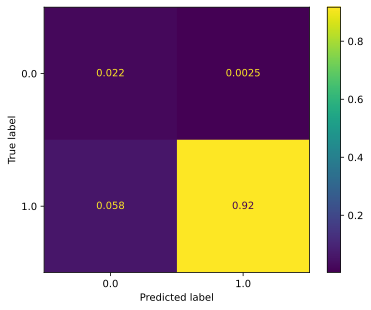

In [69]:
print(confusion_matrix(Y_test_AE, scored_test['Anomaly']))
ConfusionMatrixDisplay.from_predictions(Y_test_AE, scored_test['Anomaly'], normalize='all')

plt.show()